# Table

In [1]:
import geopandas as gpd

directory = '/Users/arthurcalvi/Data/results/disturbances/matching_france_v02_EPSG3857.parquet'
gdf = gpd.read_parquet(directory)


# Research

In [4]:
%load_ext autoreload
%autoreload 2

from chronos import research_items, get_sats, priority, config, dplatform, check_intervals, get_cc
from utils import get_nd, get_res
import pandas as pd
import numpy as np 
from shapely.geometry import shape
from rasterio.features import rasterize
from rasterio.warp import transform_geom
from copy import deepcopy
from datetime import datetime, timezone
from joblib import Parallel, delayed

verbose=1
index = 100
buffer = 3000 #meters
delta_min = 15 #days
cc1 = 3
cc2 = 75
start_date = datetime(2010, 1, 1, 10, 10, 10, tzinfo=timezone.utc)
end_date = datetime(2016, 12, 31, 10, 10, 10, tzinfo=timezone.utc)
geometry = gdf.iloc[index]['geometry']

#geometry
old_geometry = deepcopy(geometry)
geometry = transform_geom('epsg:3857', 'epsg:4326', shape(old_geometry).convex_hull)
geometry_buffer = transform_geom('epsg:3857', 'epsg:4326', shape(old_geometry).convex_hull.buffer(buffer))

#sats 
count_sat = {}
sats = get_sats(start_date, end_date, config, priority)
if verbose > 0:
    print(sats)
for sat in sats:
    count_sat[sat] = 0

#RESEARCH 1
items1 = research_items(geometry, start_date, end_date, sats, config, cc1)

#retrieve crs, transform and array for each sat

items1_sat = set([dplatform[item.properties['platform']] for item in items1])
items1_prop = {sat:None for sat in items1_sat}
for sat in items1_sat:
    i = 0 
    temp_items1 = [item for item in items1 if dplatform[item.properties['platform']] == sat]
    while items1_prop[sat] is None and i < len(temp_items1):
        item = temp_items1[i]
        try :
            crs, transfo, arr, _ = item.assets.crop_as_array(config[ dplatform[ item.properties['platform'] ] ]['qa'][0], bbox= shape(geometry).bounds)
            items1_prop[sat] = {'crs':crs, 'transfo':transfo, 'arr':arr}
        except :
            pass
        i += 1

items1_sat = [sat for sat in items1_sat if items1_prop[sat] is not None]
#retrieve aoi for each sat
daoi = {}
for sat in items1_sat:
    daoi[sat] = rasterize([transform_geom('epsg:3857', items1_prop[sat]['crs'] , old_geometry.buffer(100).convex_hull)], out_shape = items1_prop[sat]['arr'].shape[1:], transform=items1_prop[sat]['transfo'], fill=np.nan, all_touched=False)

#research and filter for landsat-7
_ = Parallel(n_jobs=-1, prefer='threads', verbose=verbose)(delayed(get_nd)(item, daoi, geometry) for item in items1)
items1 = [item for item in items1 if ('nodata' not in item.properties or item.properties['nodata'] <= 25)]

if verbose > 0:
            print(f'Items found for research 1 with cc={cc1} : {len(items1)}')
x = [start_date] + [item.properties['datetime'] for item in items1] + [end_date]
y = [None] + [sats.index( dplatform[ item.properties['platform'] ]) for item in items1] + [None]

#gap
df = pd.DataFrame(data=np.array([x,y]).T, columns=['date', 'sat'])
df['gap'] = (df.date - df.date.shift()).dt.days
df['hole'] = (df.gap > delta_min)
dates_hole = [[df.date.iloc[x-1], df.date.iloc[x]] for x in df.index.to_numpy()[df.hole]]

#RESEARCH 2 
items2 = research_items(geometry, start_date, end_date, sats, config, cc2)
dates = [item.properties['datetime'] for item in items2]
indexes_prob = [check_intervals(date, dates_hole, 1) for date in dates]
items_prob = [items2[i] for i in range(len(items2)) if indexes_prob[i]]


#retrieve crs, transform and array for each sat 
items2_sat = set([dplatform[item.properties['platform']] for item in items2])
items2_prop = items1_prop
if not sorted(items2_sat) == sorted(items1_sat):
    for sat in items2_sat:
        if sat not in items1_sat:
            count_sat[sat] = 0
            i = 0 
            temp_items2 = [item for item in items2 if dplatform[item.properties['platform']] == sat]
            while items2_prop[sat] is None and i < len(temp_items2):
                item = temp_items2[i]
                try :
                    crs, transfo, arr, _ = item.assets.crop_as_array(config[ dplatform[ item.properties['platform'] ] ]['qa'][0], bbox= shape(geometry).bounds)
                    items2_prop[sat] = {'crs':crs, 'transfo':transfo, 'arr':arr}
                except :
                    pass
                i += 1

items2 = [item for item in items2 if items2_prop[dplatform[item.properties['platform']]] is not None]
items2_sat = [sat for sat in items2_sat if items2_prop[sat] is not None]

if len(items2) > 0:
    daoi = {}
    for sat in items2_sat:
        daoi[sat] = rasterize([transform_geom('epsg:3857', items2_prop[sat]['crs'] , old_geometry.buffer(100).convex_hull)], out_shape = items2_prop[sat]['arr'].shape[1:], transform=items2_prop[sat]['transfo'], fill=np.nan, all_touched=False)
    cc_nodata = Parallel(n_jobs=-1, prefer='threads', verbose=verbose)(delayed(get_cc)(item, geometry, daoi, config) for item in items_prob)
    indexes_cc_ok = (np.array(cc_nodata)[:,0] < 25)
    indexes_nodata_ok = (np.array(cc_nodata)[:,1] < 25)
    cloud_cover = np.array(cc_nodata)[indexes_cc_ok, 0]
    nodata_cover = np.array(cc_nodata)[indexes_nodata_ok, 1]
    items_ok = [items_prob[i] for i in range(len(items_prob)) if (indexes_cc_ok[i] and indexes_nodata_ok[i])]

    #update CC:
    for i,item in enumerate(items_ok):
        item.properties['eo:cloud_cover'] = cloud_cover[i]
        item.properties['nodata'] = nodata_cover[i]

    if verbose > 0:
        print(f'Items found for research 2 with cc=25 (on aoi) : {len(items2)}')

    #assembling
    items1.extend(items_ok)
    items1 = sorted(items1, key=lambda x:x.properties['datetime'])
    _ = Parallel(n_jobs=-1, prefer='threads', verbose=verbose)(delayed(get_res)(item, geometry) for item in items1)
    if verbose > 0:
        print('Items found for combined research: ', len(items1))

    #filtering
    x = [item.properties['datetime'] for item in items1]
    cc = [item.properties['eo:cloud_cover'] for item in items1]
    nd = [item.properties.get('nodata', np.nan) for item in items1]
    res = [item.properties['resolution'] for item in items1]

    y = [sats.index(dplatform[ item.properties['platform'] ]) for item in items1]
    df = pd.DataFrame(data=np.array([x,y,cc,nd, res]).T, columns=['date', 'sat', 'cc', 'nodata', 'resolution'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['landsat-5', 'landsat-7', 'landsat-8']


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    8.2s finished


Items found for research 1 with cc=3 : 28


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:   55.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Items found for research 2 with cc=25 (on aoi) : 262


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.2s


Items found for combined research:  128


[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:   36.9s finished


# Date selection

In [5]:
df

,date,sat,cc,nodata,resolution
0,2010-03-10 10:50:29.814250+00:00,0,0.0,0.0,30
1,2010-04-11 10:50:27.147560+00:00,0,0.0,0.0,30
2,2010-04-18 10:56:36.517190+00:00,0,1,NaN,30
3,2010-05-04 10:56:32.951690+00:00,0,0.0,0.0,30
4,2010-05-05 10:51:42.905750+00:00,1,0.0,0.0,30
...,...,...,...,...,...
123,2016-10-04 10:59:46.231803+00:00,2,0.0,0.0,15
124,2016-10-20 10:59:50.890599+00:00,2,0.0,0.0,15
125,2016-11-05 10:59:50.709128+00:00,2,0.0,0.0,15
126,2016-11-21 10:59:50.808904+00:00,2,0.0,0.0,15


In [30]:
import statistics
import math
import matplotlib.pyplot as plt
import networkx as nx

def score(node, cc_ub, sr_ub, nd_ub):

    return 1/cc_ub * node['cloud_cover'] + 1/sr_ub * node['spatial_res'] + 1/nd_ub * node['nodata']

def get_scores(graph, nodes, cc_ub, sr_ub, nd_ub):
    #score 
    attribute1_list = [graph.nodes[n]['cloud_cover'] for n in nodes]
    attribute2_list = [graph.nodes[n]['spatial_res'] for n in nodes]
    attribute3_list = [graph.nodes[n]['nodata'] for n in nodes]
    return [1/cc_ub * x + 1/sr_ub * y + 1/nd_ub * z for x, y, z in zip(attribute1_list, attribute2_list, attribute3_list)], (attribute1_list, attribute2_list, attribute3_list)

def get_metrics(graph, shortest_path, cc_ub=10, sr_ub=30, nd_ub=25):
    """_summary_
    
    Args:
        graph (_type_): _description_
        shortest_path (_type_): _description_
        a (int, optional): _description_. Defaults to 1.
        b (int, optional): _description_. Defaults to 1.
        c (int, optional): _description_. Defaults to 1.

    Returns:
        _type_: _description_
    """

    #score 
    scores, (attribute1_list, attribute2_list, attribute3_list) = get_scores(graph, shortest_path, cc_ub, sr_ub, nd_ub)
    avg_score = statistics.mean(scores)
    avg_cloud_cover = statistics.mean(attribute1_list)
    avg_spatial_res = statistics.mean(attribute2_list)
    avg_nodata = statistics.mean(attribute3_list)

    #weight
    weights = [graph.edges[n]['weight'][0] for n in zip(shortest_path, shortest_path[1:])]
    avg_weight = statistics.mean(weights)
    std_dev_weight = statistics.stdev(weights)

    return avg_score, avg_cloud_cover, avg_spatial_res, avg_nodata, avg_weight, std_dev_weight

def weight_function(u, v, graph, alpha=0.1):
    """
    weight[1] between 0 and 3
    weight[0] between 0 and 30 
    To equally weight the two attributes, we divide the weight[0] by 10
    """
    return graph[u][v]['weight'][0] * alpha + graph[u][v]['weight'][1] 

def select_dates(df, target_weight=30, lower_bound=20, alpha=0.1, verbose=0, cc_ub=10, sr_ub=30, nd_ub=25):
    
    """_summary_
    Inputs :
        - df : dataframe with columns 'date', 'sat', 'cc', 'nodata', 'resolution'
        - target_weight : target weight for the path
        - lower_bound : lower bound for the time difference between two acquisitions
        - alpha : weight of the temporal dif in the weight function
        - verbose : verbosity level
        - cc_ub : upper bound for the cloud cover
        - sr_ub : upper bound for the spatial resolution
        - nd_ub : upper bound for the nodata percentage

    """

    df = df.fillna(0)
    timestamps = (df['date'] - df['date'].min() ).dt.days.to_numpy()


    #build timestamp difference matrix (adjencty matrix)
    N = len(timestamps)
    x = np.ones(N)
    deltaT = np.outer(x, timestamps) - np.outer(timestamps, x)
    ub = (df['date'] - df['date'].shift() ).dt.days.max() * 1.25

    if verbose > 0:
        print('upper bound : ', ub)
    deltaT_cond = deltaT.copy()
    deltaT_cond[ (abs(deltaT) > ub) | (abs(deltaT) < lower_bound) ] = np.nan
    deltaT_cond[ deltaT < 0 ] = np.nan

    if verbose > 1:
        plt.figure(figsize=(10, 10))
        plt.title('adjency matrix')
        plt.imshow(deltaT_cond)
        plt.colorbar(shrink=0.6, label='difference in days')
        plt.xlabel('nodes')
        plt.ylabel('nodes')
        plt.show()

    #build graph
    # Create an empty graph
    graph = nx.DiGraph()

    # Add nodes to the graph
    for i in range(len(timestamps)):
        row = df.iloc[i]
        attributes = {
            'cloud_cover': row['cc'],
            'spatial_res': row['resolution'],
            'nodata' : row['nodata'], 
            'date' : timestamps[i]
        }
        graph.add_node(i, **attributes)

    # Add edges to the graph based on the time differences
    for i in range(len(timestamps)):
        for j in range(i+1, len(timestamps)):
            time_diff = deltaT_cond[i][j]
            
            if lower_bound < time_diff < ub:
                if i < j:
                    graph.add_edge(i, j, weight = (abs(time_diff-target_weight), score(graph.nodes[j], cc_ub, sr_ub, nd_ub)))
                else:
                    graph.add_edge(j, i, weight = (abs(time_diff-target_weight), score(graph.nodes[i], cc_ub, sr_ub, nd_ub)))

    if verbose > 0:
        print('is strongly connected : ', nx.is_strongly_connected(graph))
        print('is weakly connected : ', nx.is_weakly_connected(graph))

    # Find the path that minimizes the sum of scores while considering weights with approximately the same weight
    start_node = 0
    end_node = len(timestamps) - 1
    shortest_path = None
    min_score = (math.inf, math.inf)
    buffer = 15 #days

    # Iterate over possible start and end nodes within the buffer time period
    for i in range(0, 10):
        start_date = graph.nodes[start_node]['date']
        possible_start = graph.nodes[i]
        possible_start_date = possible_start['date']
        time_diff_start = abs(possible_start_date - start_date)

        if time_diff_start <= buffer:
            for j in range(len(timestamps) - 10, len(timestamps)):
                end_date = graph.nodes[end_node]['date']
                possible_end = graph.nodes[j]
                possible_end_date = possible_end['date']
                time_diff_end = abs(possible_end_date - end_date)

                if time_diff_end <= buffer:
                    path = nx.shortest_path(graph, i, j, weight=lambda u, v, d: weight_function(u, v, graph, alpha))

                    if path is not None:
                        #compute metrics
                        avg_score, avg_cloud_cover, avg_spatial_res, avg_nodata, avg_weight, std_dev_weight = get_metrics(graph, path)
                        tmp_score = (avg_score, abs(target_weight - avg_weight))
                        if tmp_score < min_score:
                            min_score = tmp_score
                            shortest_path = path
                            print(f'Avg Score: {avg_score:.2f}, Avg Cloud cover: {avg_cloud_cover:.2f}, Avg Spatial res: {avg_spatial_res:.2f}, Avg nodata: {avg_nodata:.2f}, Avg Weight: {avg_weight:.2f}, Std Dev Weight: {std_dev_weight:.2f}')

    # Create a scatter plot of nodes
    scores, _  = get_scores(graph, graph.nodes(), cc_ub=cc_ub, sr_ub=sr_ub, nd_ub=nd_ub)
    x = [graph.nodes[n]['date'] for n in graph.nodes()]

    if verbose > 1:
        plt.figure(figsize=(20, 10))
        plt.scatter(x, scores, s=15, color='green', alpha=0.5)
        plt.title('Graph Visualization')
        plt.xlabel('Time')
        plt.ylabel('Score')

        # Add arrows to the plot for the shortest path
        for i in range(len(shortest_path) - 1):
            u = shortest_path[i]
            v = shortest_path[i+1]
            plt.arrow(x[u], scores[u], x[v] - x[u], scores[v] - scores[u], color='red', alpha=0.5, width=0.01, head_width=0.01, length_includes_head=True, linestyle='solid')

        scores_s, _ = get_scores(graph, shortest_path, cc_ub=10, sr_ub=30, nd_ub=25)
        plt.scatter([graph.nodes[n]['date'] for n in shortest_path], scores_s, marker='x', color='red')
        #compute metrics
        avg_score, average_attribute1, average_attribute2, average_attribute3, average_weight, std_dev_weight = get_metrics(graph, shortest_path)

        # Add arrows to the plot for directed edges
        plt.text(0.05, 0.75, f'Average Cloud cover: {average_attribute1:.2f}', transform=plt.gca().transAxes)
        plt.text(0.05, 0.7, f'Average Spatial res: {average_attribute2:.2f}', transform=plt.gca().transAxes)
        plt.text(0.05, 0.65, f'Average nodata: {average_attribute3:.2f}', transform=plt.gca().transAxes)

        plt.text(0.05, 0.9, f'Avg Score: {avg_score:.2f}', transform=plt.gca().transAxes)

        plt.text(0.05, 0.85, f'Average Weight: {average_weight:.2f}', transform=plt.gca().transAxes)
        plt.text(0.05, 0.8, f'Std Dev Weight: {std_dev_weight:.2f}', transform=plt.gca().transAxes)
        plt.show()

    selectionned_dates = np.zeros(N)
    selectionned_dates[shortest_path] = 1
    df['selected'] = selectionned_dates
    return df
    
  

upper bound :  270.0


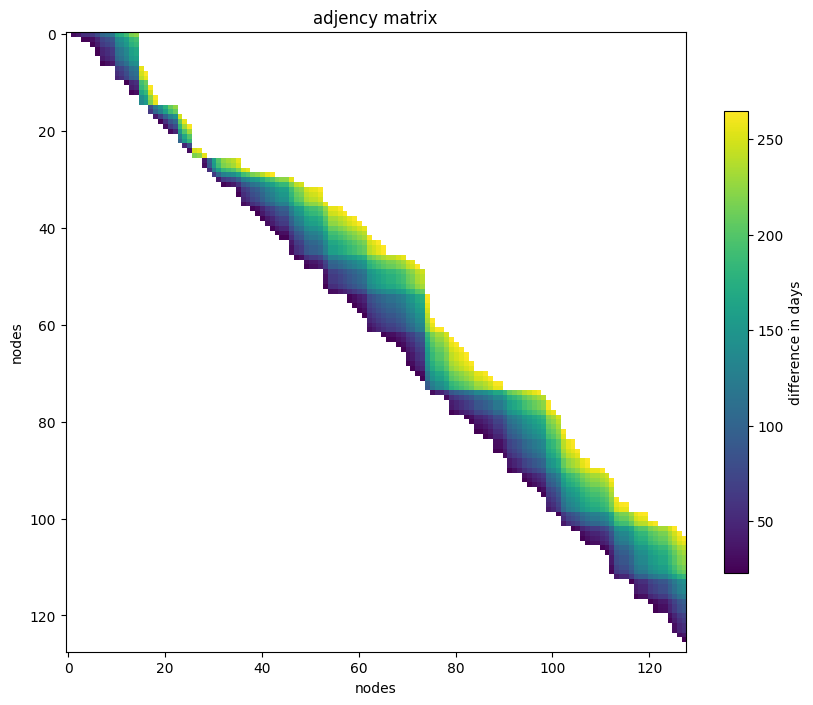

is strongly connected :  False
is weakly connected :  True
Avg Score: 0.58, Avg Cloud cover: 0.08, Avg Spatial res: 17.00, Avg nodata: 0.00, Avg Weight: 17.40, Std Dev Weight: 33.34
Avg Score: 0.58, Avg Cloud cover: 0.08, Avg Spatial res: 17.00, Avg nodata: 0.00, Avg Weight: 16.94, Std Dev Weight: 33.10


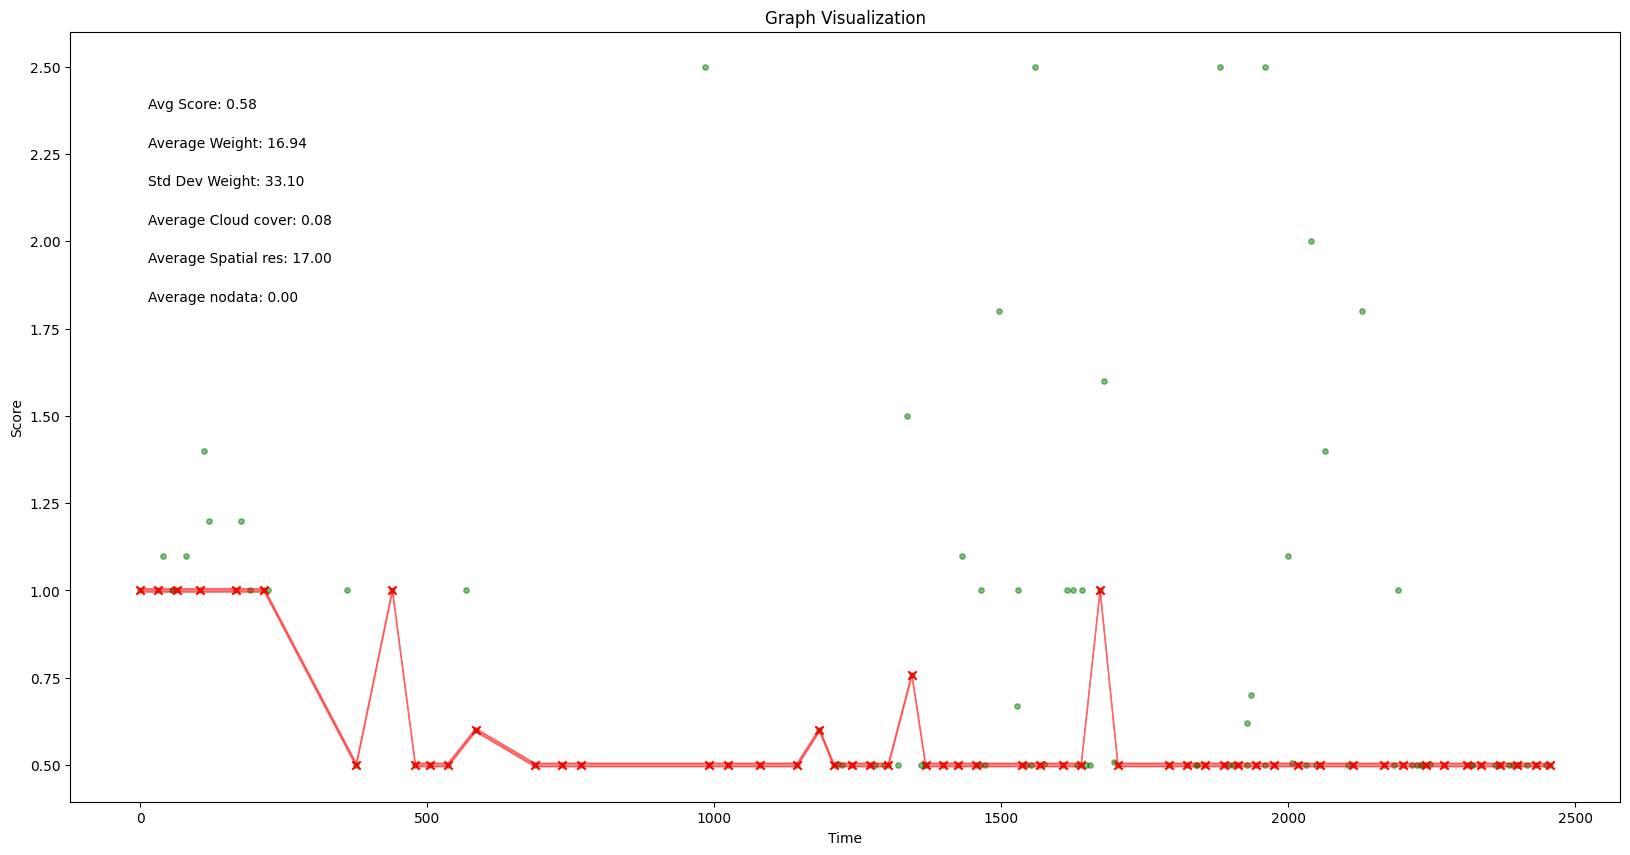

In [34]:
df = select_dates(df, target_weight=30, lower_bound=20, verbose=2, alpha=0.05, cc_ub=10, sr_ub=30, nd_ub=25)

upper bound :  270.0


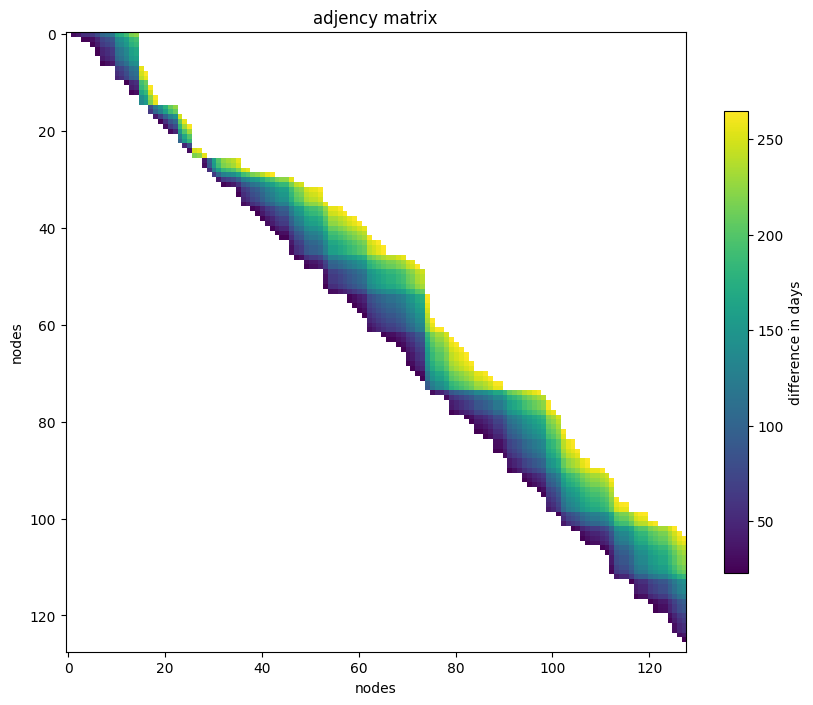

is strongly connected :  False
is weakly connected :  True
Avg Score: 0.67, Avg Cloud cover: 0.31, Avg Spatial res: 17.00, Avg nodata: 1.27, Avg Weight: 13.90, Std Dev Weight: 31.46
Avg Score: 0.67, Avg Cloud cover: 0.31, Avg Spatial res: 17.00, Avg nodata: 1.27, Avg Weight: 13.91, Std Dev Weight: 31.45


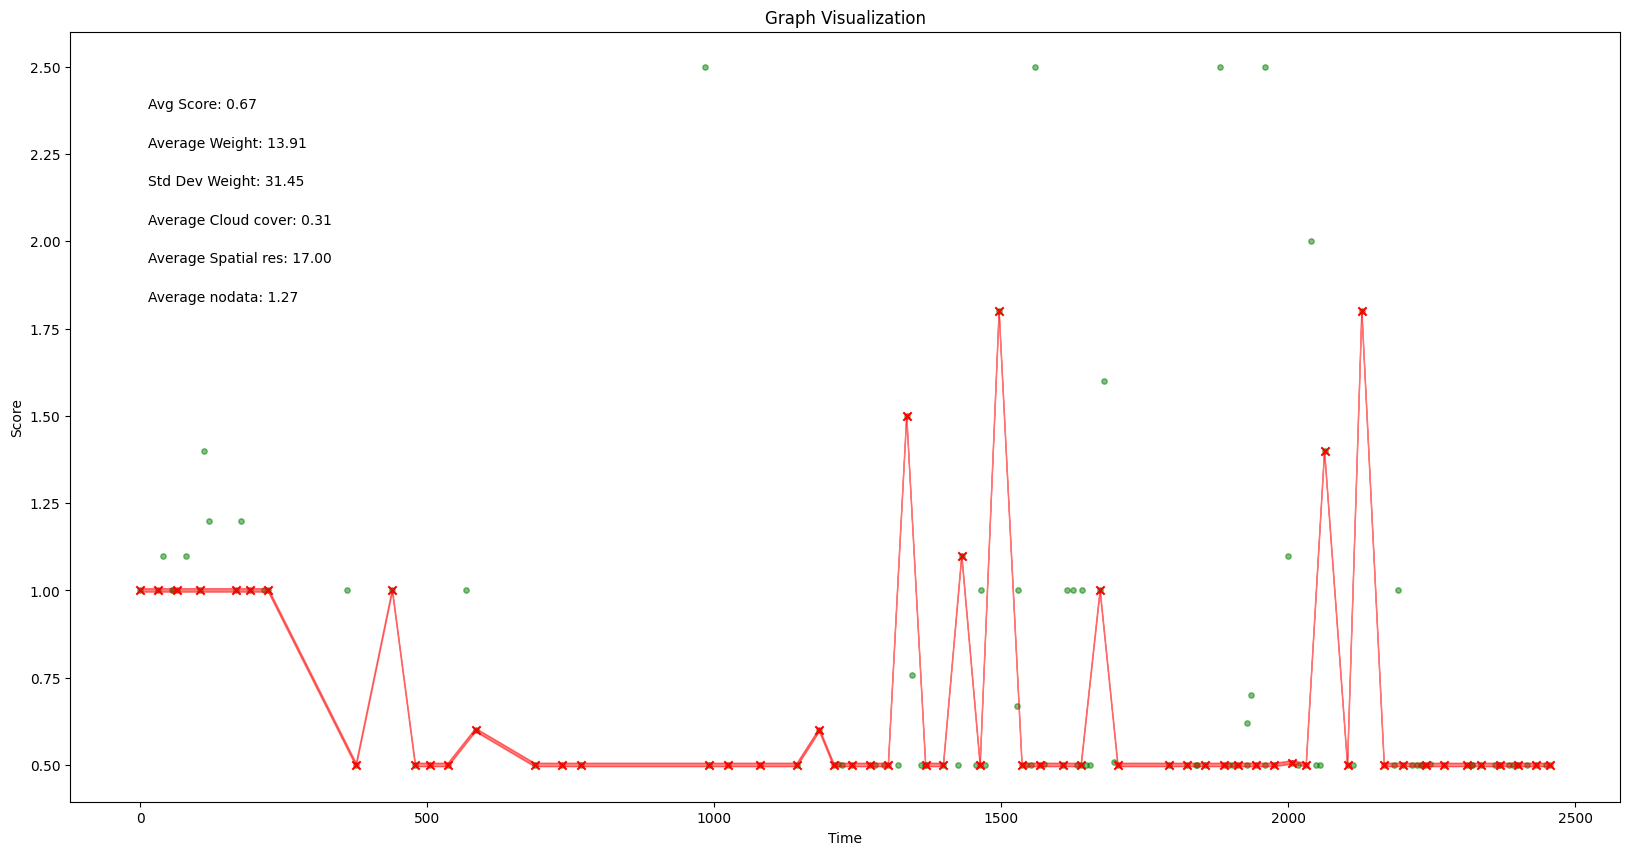

In [31]:
df = select_dates(df, target_weight=30, lower_bound=20, verbose=2, alpha=1, cc_ub=10, sr_ub=30, nd_ub=25)

## Research

upper bound :  270.0


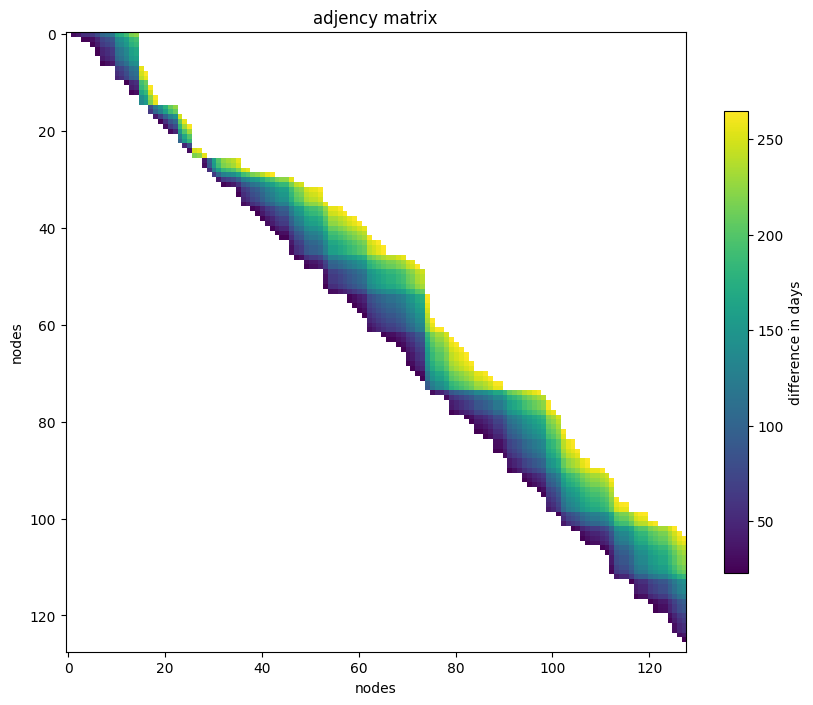

In [26]:
target_weight=30
lower_bound=20
verbose=0
cc_ub=10
sr_ub=30
nd_ub=25
verbose = 2


df = df.fillna(0)
timestamps = (df['date'] - df['date'].min() ).dt.days.to_numpy()


#build timestamp difference matrix (adjencty matrix)
N = len(timestamps)
x = np.ones(N)
deltaT = np.outer(x, timestamps) - np.outer(timestamps, x)
ub = (df['date'] - df['date'].shift() ).dt.days.max() * 1.25

if verbose > 0:
    print('upper bound : ', ub)
deltaT_cond = deltaT.copy()
deltaT_cond[ (abs(deltaT) > ub) | (abs(deltaT) < lower_bound) ] = np.nan
deltaT_cond[ deltaT < 0 ] = np.nan

if verbose > 1:
    plt.figure(figsize=(10, 10))
    plt.title('adjency matrix')
    plt.imshow(deltaT_cond)
    plt.colorbar(shrink=0.6, label='difference in days')
    plt.xlabel('nodes')
    plt.ylabel('nodes')
    plt.show()

#build graph
# Create an empty graph
graph = nx.DiGraph()

# Add nodes to the graph
for i in range(len(timestamps)):
    row = df.iloc[i]
    attributes = {
        'cloud_cover': row['cc'],
        'spatial_res': row['resolution'],
        'nodata' : row['nodata'], 
        'date' : timestamps[i]
    }
    graph.add_node(i, **attributes)

# Add edges to the graph based on the time differences
for i in range(len(timestamps)):
    for j in range(i+1, len(timestamps)):
        time_diff = deltaT_cond[i][j]
        
        if lower_bound < time_diff < ub:
            if i < j:
                graph.add_edge(i, j, weight = (abs(time_diff-target_weight), score(graph.nodes[j], cc_ub, sr_ub, nd_ub)))
            else:
                graph.add_edge(j, i, weight = (abs(time_diff-target_weight), score(graph.nodes[i], cc_ub, sr_ub, nd_ub)))

In [27]:
graph.edges(data=True)

OutEdgeDataView([(0, 1, {'weight': (1.0, 1.0)}), (0, 2, {'weight': (9.0, 1.1)}), (0, 3, {'weight': (25.0, 1.0)}), (0, 4, {'weight': (26.0, 1.0)}), (0, 5, {'weight': (33.0, 1.0)}), (0, 6, {'weight': (49.0, 1.1)}), (0, 7, {'weight': (73.0, 1.0)}), (0, 8, {'weight': (81.0, 1.4)}), (0, 9, {'weight': (89.0, 1.2)}), (0, 10, {'weight': (137.0, 1.0)}), (0, 11, {'weight': (145.0, 1.2)}), (0, 12, {'weight': (161.0, 1.0)}), (0, 13, {'weight': (186.0, 1.0)}), (0, 14, {'weight': (193.0, 1.0)}), (1, 3, {'weight': (6.0, 1.0)}), (1, 4, {'weight': (5.0, 1.0)}), (1, 5, {'weight': (2.0, 1.0)}), (1, 6, {'weight': (18.0, 1.1)}), (1, 7, {'weight': (42.0, 1.0)}), (1, 8, {'weight': (50.0, 1.4)}), (1, 9, {'weight': (58.0, 1.2)}), (1, 10, {'weight': (106.0, 1.0)}), (1, 11, {'weight': (114.0, 1.2)}), (1, 12, {'weight': (130.0, 1.0)}), (1, 13, {'weight': (155.0, 1.0)}), (1, 14, {'weight': (162.0, 1.0)}), (2, 5, {'weight': (6.0, 1.0)}), (2, 6, {'weight': (10.0, 1.1)}), (2, 7, {'weight': (34.0, 1.0)}), (2, 8, {'wei

In [21]:
def weight_function(u, v, graph, alpha=0.1):
    """
    weight[1] between 0 and 3
    weight[0] between 0 and 30 
    To equally weight the two attributes, we divide the weight[0] by 10
    """
    return graph[u][v]['weight'][0] * alpha + graph[u][v]['weight'][1] 

path = nx.shortest_path(graph, 0, len(graph.nodes())-1, weight=lambda u, v, d: weight_function(u, v, graph))

In [28]:
def get_metrics(graph, shortest_path, cc_ub=10, sr_ub=30, nd_ub=25):
    """_summary_
    
    Args:
        graph (_type_): _description_
        shortest_path (_type_): _description_
        a (int, optional): _description_. Defaults to 1.
        b (int, optional): _description_. Defaults to 1.
        c (int, optional): _description_. Defaults to 1.

    Returns:
        _type_: _description_
    """

    #score 
    scores, (attribute1_list, attribute2_list, attribute3_list) = get_scores(graph, shortest_path, cc_ub, sr_ub, nd_ub)
    avg_score = statistics.mean(scores)
    avg_cloud_cover = statistics.mean(attribute1_list)
    avg_spatial_res = statistics.mean(attribute2_list)
    avg_nodata = statistics.mean(attribute3_list)

    #weight
    weights = [graph.edges[n]['weight'][0] for n in zip(shortest_path, shortest_path[1:])]
    avg_weight = statistics.mean(weights)
    std_dev_weight = statistics.stdev(weights)

    return avg_score, avg_cloud_cover, avg_spatial_res, avg_nodata, avg_weight, std_dev_weight

is strongly connected :  False
is weakly connected :  True
Avg Score: 0.67, Avg Cloud cover: 0.31, Avg Spatial res: 17.00, Avg nodata: 1.27, Avg Weight: 13.91, Std Dev Weight: 31.45


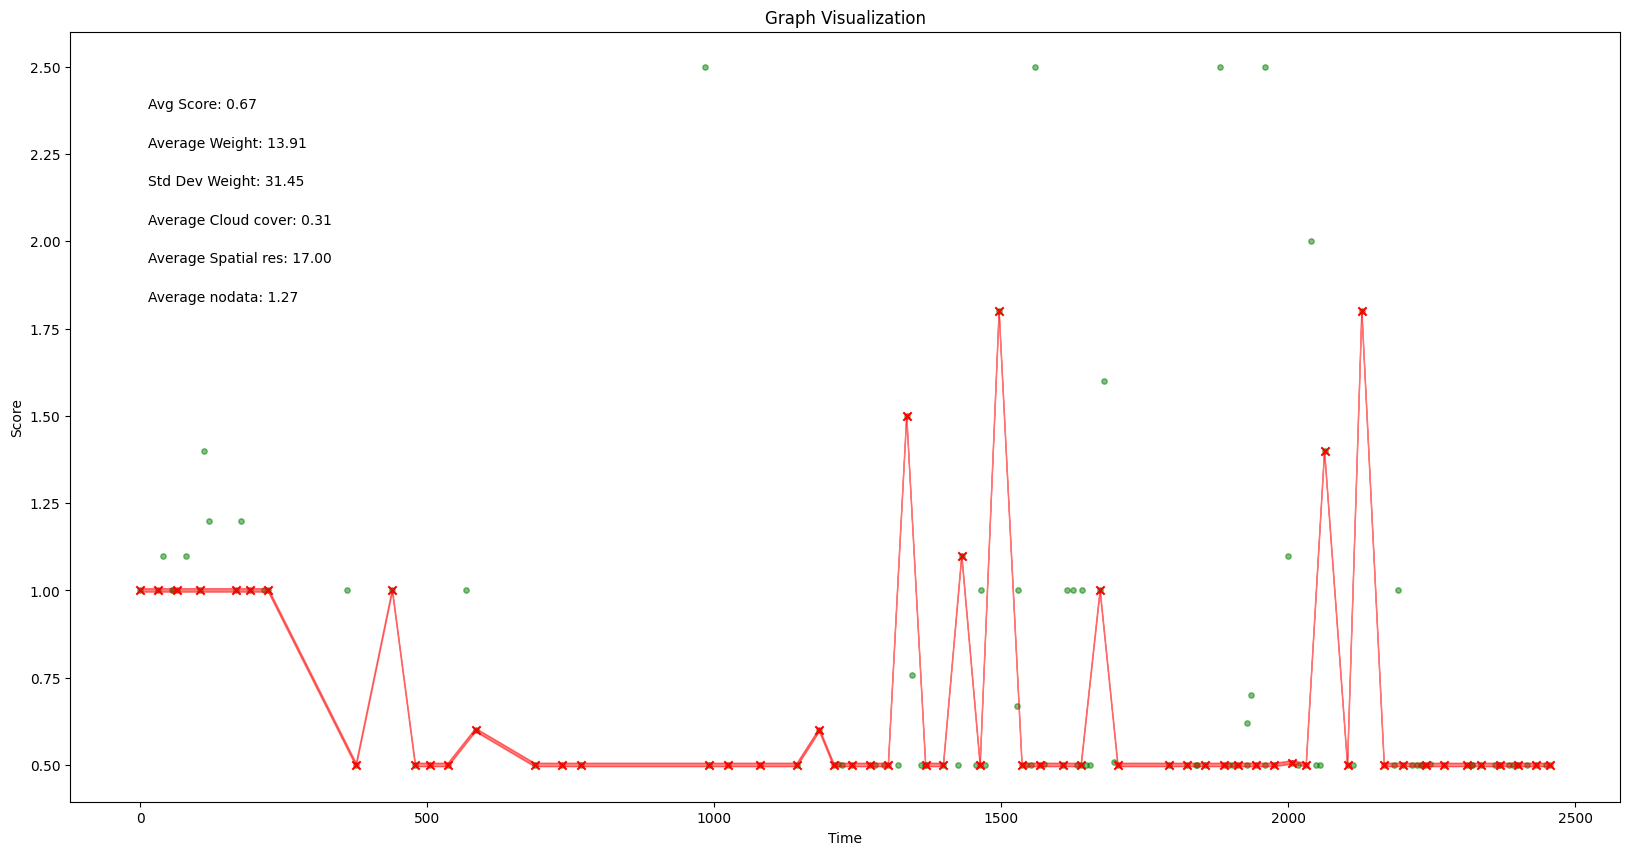

In [29]:
if verbose > 0:
    print('is strongly connected : ', nx.is_strongly_connected(graph))
    print('is weakly connected : ', nx.is_weakly_connected(graph))

# Find the path that minimizes the sum of scores while considering weights with approximately the same weight
start_node = 0
end_node = len(timestamps) - 1
shortest_path = None
min_score = (math.inf, math.inf)
buffer = 15 #days

# Iterate over possible start and end nodes within the buffer time period
for i in range(0, 10):
    start_date = graph.nodes[start_node]['date']
    possible_start = graph.nodes[i]
    possible_start_date = possible_start['date']
    time_diff_start = abs(possible_start_date - start_date)

    if time_diff_start <= buffer:
        for j in range(len(timestamps) - 10, len(timestamps)):
            end_date = graph.nodes[end_node]['date']
            possible_end = graph.nodes[j]
            possible_end_date = possible_end['date']
            time_diff_end = abs(possible_end_date - end_date)

            if time_diff_end <= buffer:
                path = nx.shortest_path(graph, 0, len(graph.nodes())-1, weight=lambda u, v, d: weight_function(u, v, graph))

                if path is not None:
                    #compute metrics
                    avg_score, avg_cloud_cover, avg_spatial_res, avg_nodata, avg_weight, std_dev_weight = get_metrics(graph, path)
                    tmp_score = (avg_score, abs(target_weight - avg_weight))
                    if tmp_score < min_score:
                        min_score = tmp_score
                        shortest_path = path
                        print(f'Avg Score: {avg_score:.2f}, Avg Cloud cover: {avg_cloud_cover:.2f}, Avg Spatial res: {avg_spatial_res:.2f}, Avg nodata: {avg_nodata:.2f}, Avg Weight: {avg_weight:.2f}, Std Dev Weight: {std_dev_weight:.2f}')

# Create a scatter plot of nodes
scores, _  = get_scores(graph, graph.nodes(), cc_ub=cc_ub, sr_ub=sr_ub, nd_ub=nd_ub)
x = [graph.nodes[n]['date'] for n in graph.nodes()]

if verbose > 1:
    plt.figure(figsize=(20, 10))
    plt.scatter(x, scores, s=15, color='green', alpha=0.5)
    plt.title('Graph Visualization')
    plt.xlabel('Time')
    plt.ylabel('Score')

    # Add arrows to the plot for the shortest path
    for i in range(len(shortest_path) - 1):
        u = shortest_path[i]
        v = shortest_path[i+1]
        plt.arrow(x[u], scores[u], x[v] - x[u], scores[v] - scores[u], color='red', alpha=0.5, width=0.01, head_width=0.01, length_includes_head=True, linestyle='solid')

    scores_s, _ = get_scores(graph, shortest_path, cc_ub=10, sr_ub=30, nd_ub=25)
    plt.scatter([graph.nodes[n]['date'] for n in shortest_path], scores_s, marker='x', color='red')
    #compute metrics
    avg_score, average_attribute1, average_attribute2, average_attribute3, average_weight, std_dev_weight = get_metrics(graph, shortest_path)

    # Add arrows to the plot for directed edges
    plt.text(0.05, 0.75, f'Average Cloud cover: {average_attribute1:.2f}', transform=plt.gca().transAxes)
    plt.text(0.05, 0.7, f'Average Spatial res: {average_attribute2:.2f}', transform=plt.gca().transAxes)
    plt.text(0.05, 0.65, f'Average nodata: {average_attribute3:.2f}', transform=plt.gca().transAxes)

    plt.text(0.05, 0.9, f'Avg Score: {avg_score:.2f}', transform=plt.gca().transAxes)

    plt.text(0.05, 0.85, f'Average Weight: {average_weight:.2f}', transform=plt.gca().transAxes)
    plt.text(0.05, 0.8, f'Std Dev Weight: {std_dev_weight:.2f}', transform=plt.gca().transAxes)
    plt.show()

selectionned_dates = np.zeros(N)
selectionned_dates[shortest_path] = 1
df['selected'] = selectionned_dates
    